Authors: Nihir Chadderwala, Lenin Arivukadal<br>
Big Data and it's applications Final Project

# Predicting user activity using accelerometer signals from cell phone

## Introduction

These days all the modern cell phones i.e. smartphones are equipped with wide range of
sensors from motion detectors, facial recognition, checking heart rate, tracking human activity,
etc. The data collected by these sensors are then used by various applications on the smart
phone to not only keep track of user’s lifestyle but also provide suggestions to improve lifestyle.
For this project, we will be making use of data provided by UC Irvine machine learning repository
https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones

# ETL Phase: Load and preprocess the data

The Dataset for ADL Recognition with Wrist-worn Accelerometer is a public collection of labelled accelerometer data recordings to be used for the creation and validation of acceleration models of simple ADL. 

The Dataset is composed of physical activities such as standing, walking, sitting, laying, walking downstairs and walking upstairs. 

The data are collected by a single tri-axial accelerometer attached to the right-wrist of the volunteer.

# Data Loading

In [1]:
# import libraries
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
def format_data_x(datafile):
    x_data = None
    for item in datafile:
        item_data = np.loadtxt(item, dtype=np.float)
        if x_data is None:
            x_data = np.zeros((len(item_data), 1))
        x_data = np.hstack((x_data, item_data))
    x_data = x_data[:, 1:]
    print(x_data.shape)
    X = None
    for i in range(len(x_data)):
        row = np.asarray(x_data[i, :])
        row = row.reshape(9, 128).T
        if X is None:
            X = np.zeros((len(x_data), 128, 9))
        X[i] = row
    print(X.shape)
    return X


def format_data_y(datafile):
    data = np.loadtxt(datafile, dtype=np.int) - 1
    YY = np.eye(6)[data]
    return YY

def load_data(path):
    str_folder = path + '/UCI HAR Dataset/'
    INPUT_SIGNAL_TYPES = [
        "body_acc_x_",
        "body_acc_y_",
        "body_acc_z_",
        "body_gyro_x_",
        "body_gyro_y_",
        "body_gyro_z_",
        "total_acc_x_",
        "total_acc_y_",
        "total_acc_z_"
    ]

    str_train_files = [str_folder + 'train/' + 'Inertial Signals/' + item + 'train.txt' for item in
                       INPUT_SIGNAL_TYPES]
    str_test_files = [str_folder + 'test/' + 'Inertial Signals/' + item + 'test.txt' for item in INPUT_SIGNAL_TYPES]
    str_train_y = str_folder + 'train/y_train.txt'
    str_test_y = str_folder + 'test/y_test.txt'

    X_train = format_data_x(str_train_files)
    X_test = format_data_x(str_test_files)
    Y_train = format_data_y(str_train_y)
    Y_test = format_data_y(str_test_y)
    return X_train, X_test, Y_train, Y_test

In [3]:
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

In [4]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [6]:
data = pd.concat([train, test], axis=0).reset_index(drop=True)

In [7]:
labels = data['Activity']

In [8]:
labels.unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

# Exploratory Data Analysis

In [9]:
data.shape

(10299, 563)

There are 10299 data points with 563 attributes

In [10]:
data.isna().sum().sum()

0

As we can see, there are no missing data in the dataset

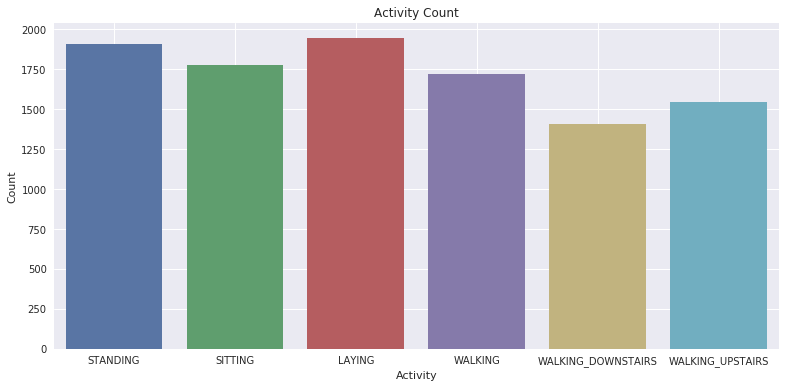

In [11]:
# Plot the number of classes (labels)
sns.set(rc={'figure.figsize':(13,6)})
fig = sns.countplot(x = "Activity" , data = data)
plt.xlabel("Activity")
plt.ylabel("Count")
plt.title("Activity Count")
plt.grid(True)
plt.show(fig)

We have enough data points for each class that we will need to classify. 

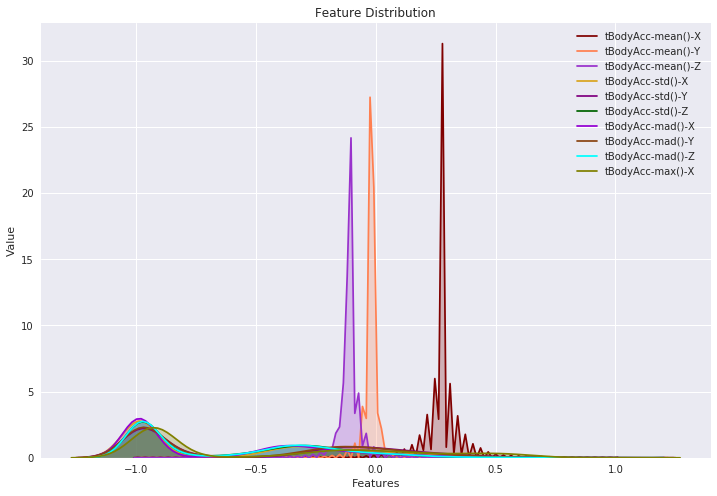

In [12]:
# Feature distribution for first 10 columns
sns.set(rc={'figure.figsize':(12,8)})
colors = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in data.columns[0:10]:
    index = index + 1
    fig = sns.kdeplot(data[i] , shade=True, color=colors[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

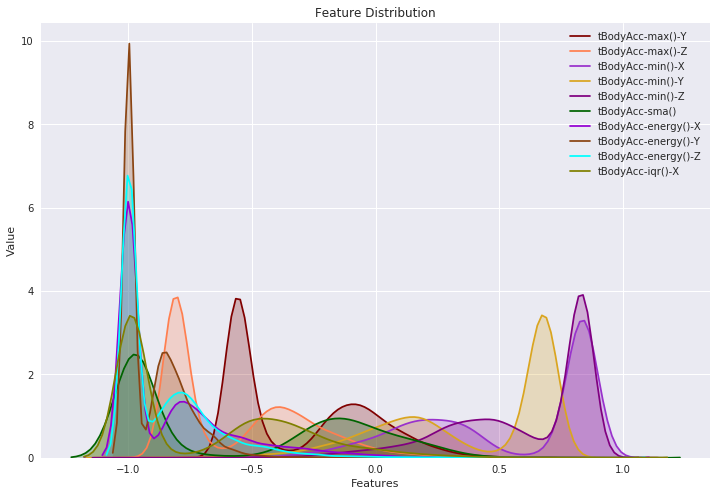

In [13]:
# Feature distribution for columns 10 to 20
sns.set(rc={'figure.figsize':(12,8)})
colors = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in data.columns[10:20]:
    index = index + 1
    ax1 = sns.kdeplot(data[i] , shade=True, color=colors[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

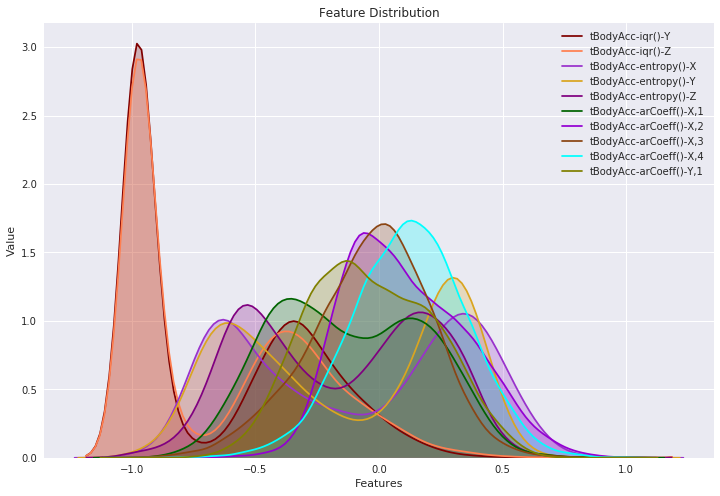

In [14]:
sns.set(rc={'figure.figsize':(12,8)})
colors = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in data.columns[20:30]:
    index = index + 1
    ax1 = sns.kdeplot(data[i] , shade=True, color=colors[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

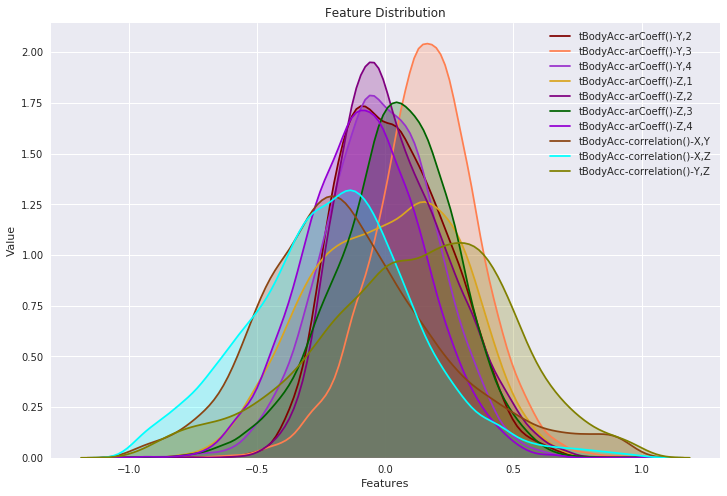

In [15]:
sns.set(rc={'figure.figsize':(12,8)})
colors = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in data.columns[30:40]:
    index = index + 1
    ax1 = sns.kdeplot(data[i] , shade=True, color=colors[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

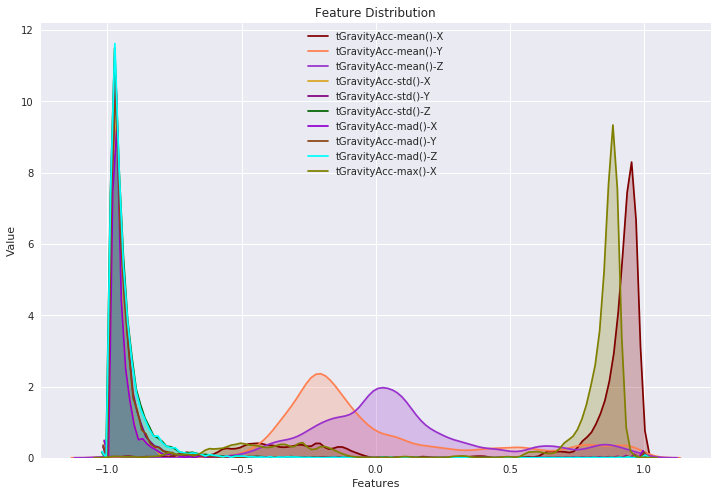

In [16]:
sns.set(rc={'figure.figsize':(12,8)})
colors = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in data.columns[40:50]:
    index = index + 1
    ax1 = sns.kdeplot(data[i] , shade=True, color=colors[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

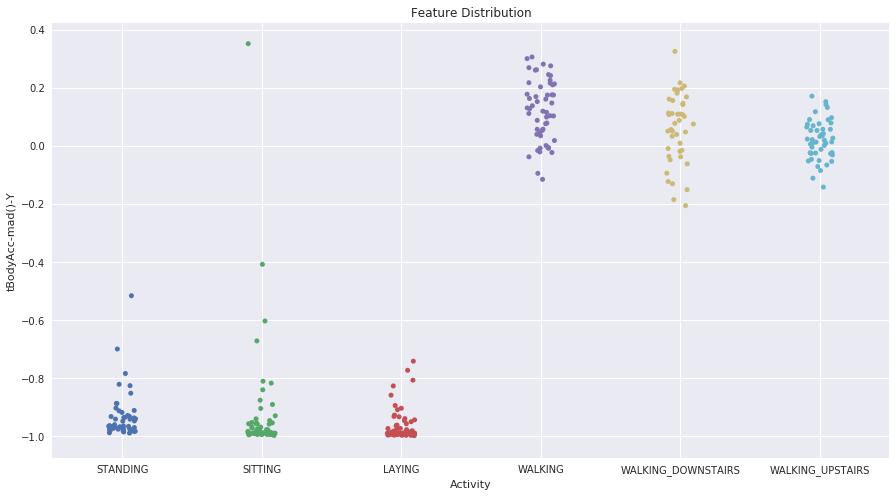

In [17]:
sns.set(rc={'figure.figsize':(15,8)})
fig1 = sns.stripplot(x='Activity', y=data.loc[data['subject']==15].iloc[:,7], data=data.loc[data['subject']==15], jitter=True)
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig1)

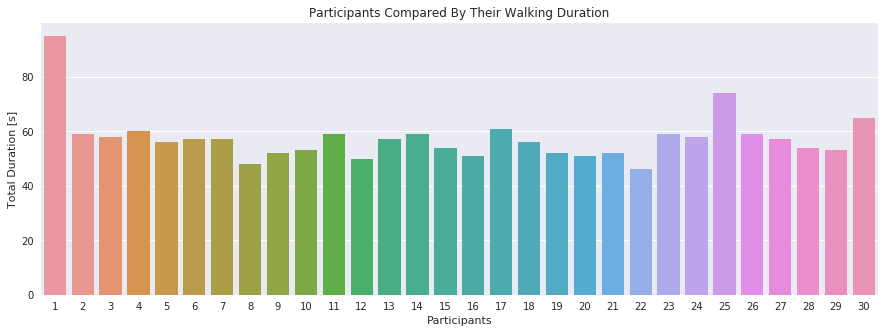

In [18]:
duration = (data[data['Activity'] == 'WALKING'].groupby('subject')['Activity'].count())

plot_data = duration.reset_index().sort_values('Activity', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Activity')
plt.title('Participants Compared By Their Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

In [19]:
train_data = data.drop('Activity', axis=1)
train_labels = data['Activity']

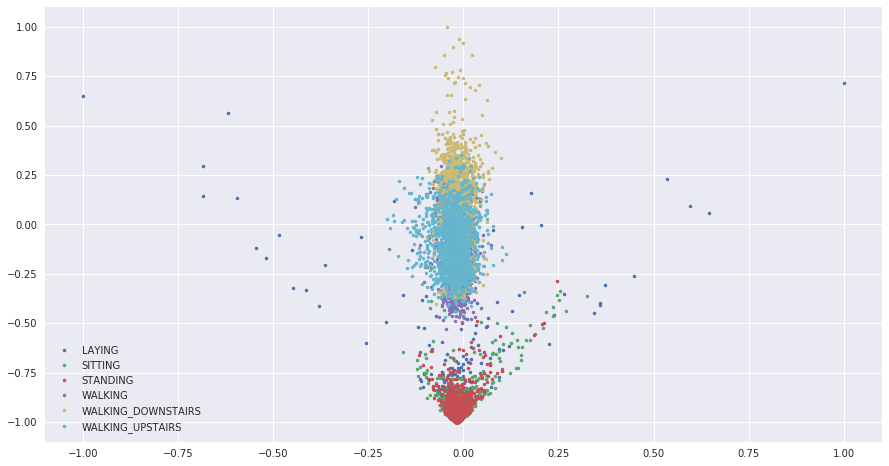

In [20]:
groups = data.groupby('Activity')

for name, group in groups:
    plt.plot(group['tBodyAcc-mean()-Y'], group['tBodyAccMag-mean()'], '.', label=name)

plt.legend(loc='best')
plt.show()

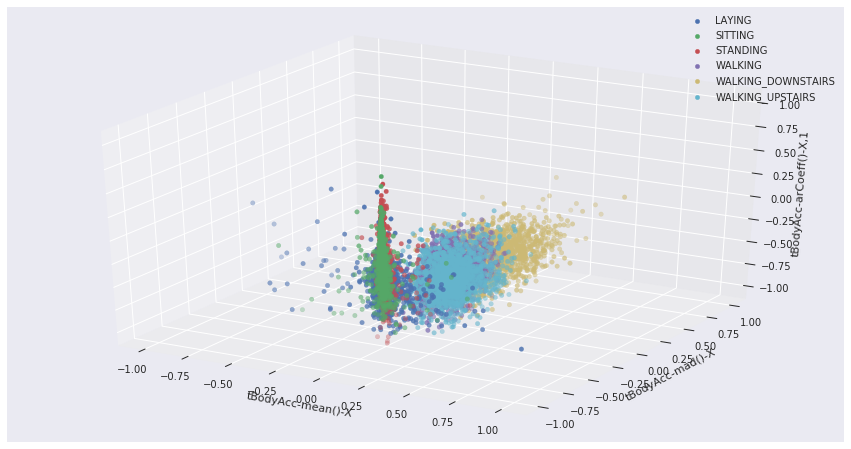

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for name, group in groups:
    ax.scatter(group['tBodyAcc-mean()-X'],group['tBodyAcc-mad()-X'],group['tBodyAcc-arCoeff()-X,1'],'.',label=name)
ax.set_xlabel('tBodyAcc-mean()-X')
ax.set_ylabel('tBodyAcc-mad()-X')
ax.set_zlabel('tBodyAcc-arCoeff()-X,1')
ax.legend()
plt.show()

# Base Model

In [22]:
from sklearn.preprocessing import LabelBinarizer

binarizer = LabelBinarizer().fit(train.Activity)
X_train = train.drop(['subject', 'Activity'], axis=1).as_matrix()
y_train = binarizer.transform(train.Activity)
X_test = test.drop(['subject', 'Activity'], axis=1).as_matrix()
y_test = binarizer.transform(test.Activity)

In [23]:
X_train.shape

(7352, 561)

In [24]:
y_train.shape

(7352, 6)

In [25]:
y_test.shape

(2947, 6)

In [40]:
INPUT_FEATURES = 561
LEARNING_RATE = 0.001
OUTPUT_DIMENSION = 6
BATCH_SIZE = 100
EPOCHS = 200

In [27]:
X = tf.placeholder(tf.float32, [None, INPUT_FEATURES])

In [26]:
layer1_weight = tf.Variable(tf.truncated_normal([561, 1024], stddev=0.1))
layer1_bias = tf.Variable(tf.truncated_normal([1024], stddev=0.1))
layer1 = tf.nn.relu(tf.matmul(X, layer1_weight) + layer1_bias)

layer2_weight = tf.Variable(tf.truncated_normal([1024, 512], stddev=0.1))
layer2_bias = tf.Variable(tf.truncated_normal([512], stddev=0.1))
layer2 = tf.nn.relu(tf.matmul(layer1, layer2_weight) + layer2_bias)

layer3_weight = tf.Variable(tf.truncated_normal([512, 256], stddev=0.1))
layer3_bias = tf.Variable(tf.truncated_normal([256], stddev=0.1))
layer3 = tf.nn.relu(tf.matmul(layer2, layer3_weight) + layer3_bias)

output_weight = tf.Variable(tf.truncated_normal([256, OUTPUT_DIMENSION], stddev=0.1))
output_bias = tf.Variable(tf.truncated_normal([6], stddev=0.1))
output_layer = tf.matmul(layer3, output_weight) + output_bias

Instructions for updating:
Colocations handled automatically by placer.


In [28]:
y = tf.placeholder(tf.float32, [None, OUTPUT_DIMENSION])

In [28]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_layer))
optimizer = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [29]:
init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [30]:
prediction = tf.equal(tf.argmax(output_layer,1), tf.argmax(y,1))
score = tf.reduce_mean(tf.cast(prediction, "float"))

In [35]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for i in range(EPOCHS):
    _, cost = sess.run([optimizer, loss], feed_dict = {
        X: X_train,
        y: y_train
    })
    print("Average loss in epoch %d: %.5f" %(i, np.mean(cost)))


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Average loss in epoch 0: 2.65915
Average loss in epoch 1: 1.70576
Average loss in epoch 2: 1.59684
Average loss in epoch 3: 1.37539
Average loss in epoch 4: 1.14845
Average loss in epoch 5: 0.97566
Average loss in epoch 6: 0.89262
Average loss in epoch 7: 0.85993
Average loss in epoch 8: 0.76443
Average loss in epoch 9: 0.68620
Average loss in epoch 10: 0.63951
Average loss in epoch 11: 0.58622
Average loss in epoch 12: 0.54244
Average loss in epoch 13: 0.51778
Average loss in epoch 14: 0.48549
Average loss in epoch 15: 0.45174
Average loss in epoch 16: 0.42230
Average loss in epoch 17: 0.40135
Average loss in epoch 18: 0.37365
Average loss in epoch 19: 0.35650
Average loss in epoch 20: 0.34290
Average loss in epoch 21: 0.32333
Average loss in epoch 22: 0.31192
Average loss in epoch 23: 0.30042
Average loss in epoch 24: 0.28093
Average loss in epoch 25: 0.26884
Average loss in epoch 26: 0.26387
Average loss in epoch 27: 0.25312
Average loss in epoch 28: 0.24232
Average loss in epoch 29

In [32]:
accuracy = sess.run(score, feed_dict={
    X: X_test,
    y: y_test
})
print(accuracy)

0.9491008


# Confusion Matrix

In [33]:
preds = sess.run(output_layer, feed_dict={
        X: X_test
})

In [34]:
y_test.shape

(2947, 6)

In [36]:
confusion = tf.confusion_matrix(labels=tf.argmax(y_test, 1), predictions=tf.argmax(preds, 1), num_classes=OUTPUT_DIMENSION)

In [38]:
confusion_matrix = confusion.eval(session=sess)

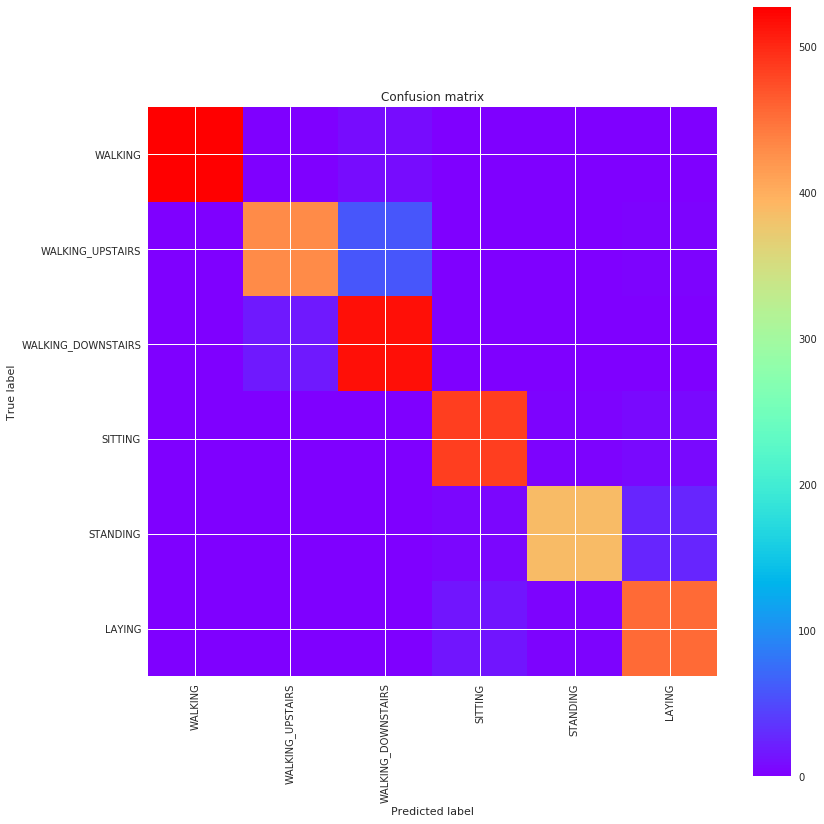

In [41]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [30]:
layer1_weight = tf.Variable(tf.truncated_normal([561, 561], stddev=0.1))
layer1_bias = tf.Variable(tf.truncated_normal([561], stddev=0.1))
layer1 = tf.nn.relu(tf.matmul(X, layer1_weight) + layer1_bias)

layer2_weight = tf.Variable(tf.truncated_normal([561, 256], stddev=0.1))
layer2_bias = tf.Variable(tf.truncated_normal([256], stddev=0.1))
layer2 = tf.nn.relu(tf.matmul(layer1, layer2_weight) + layer2_bias)

layer3_weight = tf.Variable(tf.truncated_normal([256, 64], stddev=0.1))
layer3_bias = tf.Variable(tf.truncated_normal([64], stddev=0.1))
layer3 = tf.nn.relu(tf.matmul(layer2, layer3_weight) + layer3_bias)

output_weight = tf.Variable(tf.truncated_normal([64, OUTPUT_DIMENSION], stddev=0.1))
output_bias = tf.Variable(tf.truncated_normal([6], stddev=0.1))
output_layer = tf.matmul(layer3, output_weight) + output_bias

Instructions for updating:
Colocations handled automatically by placer.


In [42]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_layer))
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

In [43]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for i in range(EPOCHS):
    _, cost = sess.run([optimizer, loss], feed_dict = {
        X: X_train,
        y: y_train
    })
    print("Average loss in epoch %d: %.5f" %(i, np.mean(cost)))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Average loss in epoch 0: 2.31808
Average loss in epoch 1: 1.79445
Average loss in epoch 2: 1.42206
Average loss in epoch 3: 1.29593
Average loss in epoch 4: 1.12677
Average loss in epoch 5: 0.96160
Average loss in epoch 6: 0.86756
Average loss in epoch 7: 0.77675
Average loss in epoch 8: 0.69742
Average loss in epoch 9: 0.64828
Average loss in epoch 10: 0.58499
Average loss in epoch 11: 0.54829
Average loss in epoch 12: 0.49228
Average loss in epoch 13: 0.47579
Average loss in epoch 14: 0.43559
Average loss in epoch 15: 0.41221
Average loss in epoch 16: 0.39125
Average loss in epoch 17: 0.36465
Average loss in epoch 18: 0.34929
Average loss in epoch 19: 0.33098
Average loss in epoch 20: 0.31238
Average loss in epoch 21: 0.29907
Average loss in epoch 22: 0.28379
Average loss in epoch 23: 0.26990
Average loss in epoch 24: 0.26059
Average loss in epoch 25: 0.24673
Average loss in epoch 26: 0.23697
Average loss in epoch 27: 0.22911
Average loss in epoch 28: 0.21940
Average loss in epoch 29

In [44]:
prediction = tf.equal(tf.argmax(output_layer,1), tf.argmax(y,1))
score = tf.reduce_mean(tf.cast(prediction, "float"))

In [45]:
accuracy = sess.run(score, feed_dict={
    X: X_test,
    y: y_test
})
print(accuracy)

0.9470648


# Feature Engineering

In [36]:
#list(X_train.columns)

In [37]:
# X_train['newJerkMag'] = X_train['tBodyGyroJerkMag-sma()'] * X_train['tBodyGyro-arCoeff()-Y,1']
# X_test['newJerkMag'] = X_test['tBodyGyroJerkMag-sma()'] * X_test['tBodyGyro-arCoeff()-Y,1']

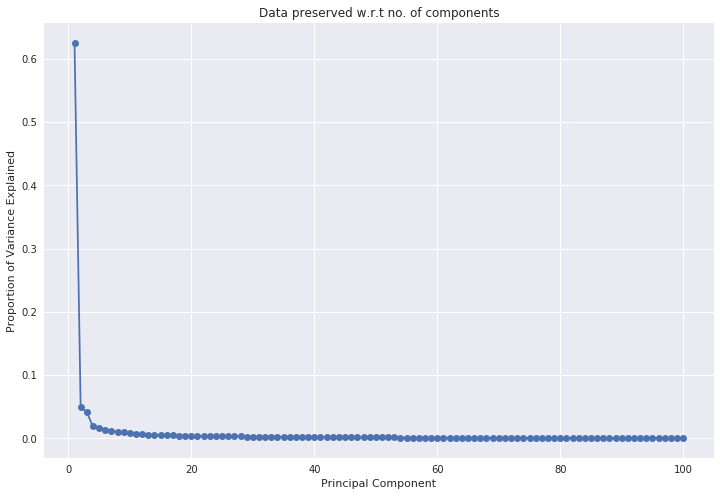

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
train_pca = pca.fit_transform(X_train)
test_pca = pca.transform(X_test)

plt.figure(figsize=(12,8))
plt.plot(range(1,101), pca.explained_variance_ratio_, '-o')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.title("Data preserved w.r.t no. of components")
plt.show()

## Re-training model after feature engineering and dimensionality reduction

In [52]:
pca_20 = PCA(n_components=20)
train_pca_20 = pca_20.fit_transform(X_train)
test_pca_20 = pca_20.transform(X_test)

In [53]:
sess.close()
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [54]:
train_pca_20.shape

(7352, 20)

In [55]:
X = tf.placeholder(tf.float32, [None, 20])

In [56]:
layer1_weight = tf.Variable(tf.truncated_normal([20, 1024], stddev=0.1))
layer1_bias = tf.Variable(tf.truncated_normal([1024], stddev=0.1))
layer1 = tf.nn.relu(tf.matmul(X, layer1_weight) + layer1_bias)

layer2_weight = tf.Variable(tf.truncated_normal([1024, 512], stddev=0.1))
layer2_bias = tf.Variable(tf.truncated_normal([512], stddev=0.1))
layer2 = tf.nn.relu(tf.matmul(layer1, layer2_weight) + layer2_bias)

layer3_weight = tf.Variable(tf.truncated_normal([512, 256], stddev=0.1))
layer3_bias = tf.Variable(tf.truncated_normal([256], stddev=0.1))
layer3 = tf.nn.relu(tf.matmul(layer2, layer3_weight) + layer3_bias)

output_weight = tf.Variable(tf.truncated_normal([256, OUTPUT_DIMENSION], stddev=0.1))
output_bias = tf.Variable(tf.truncated_normal([6], stddev=0.1))
output_layer = tf.matmul(layer3, output_weight) + output_bias

In [57]:
y = tf.placeholder(tf.float32, [None, OUTPUT_DIMENSION])

In [58]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_layer))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [59]:
tf.global_variables_initializer().run()
for i in range(EPOCHS):
    _, cost = sess.run([optimizer, loss], feed_dict = {
        X: train_pca_20,
        y: y_train
    })
    print("Average loss in epoch %d: %.5f" %(i, np.mean(cost)))

Average loss in epoch 0: 2.36849
Average loss in epoch 1: 1.40773
Average loss in epoch 2: 1.06741
Average loss in epoch 3: 0.67240
Average loss in epoch 4: 0.42112
Average loss in epoch 5: 0.54149
Average loss in epoch 6: 0.49683
Average loss in epoch 7: 0.33854
Average loss in epoch 8: 0.28806
Average loss in epoch 9: 0.33592
Average loss in epoch 10: 0.34646
Average loss in epoch 11: 0.30494
Average loss in epoch 12: 0.25635
Average loss in epoch 13: 0.23684
Average loss in epoch 14: 0.25238
Average loss in epoch 15: 0.26695
Average loss in epoch 16: 0.25348
Average loss in epoch 17: 0.22262
Average loss in epoch 18: 0.20371
Average loss in epoch 19: 0.20834
Average loss in epoch 20: 0.21928
Average loss in epoch 21: 0.21663
Average loss in epoch 22: 0.20150
Average loss in epoch 23: 0.18744
Average loss in epoch 24: 0.18360
Average loss in epoch 25: 0.18765
Average loss in epoch 26: 0.18928
Average loss in epoch 27: 0.18263
Average loss in epoch 28: 0.17286
Average loss in epoch 29

In [60]:
prediction = tf.equal(tf.argmax(output_layer,1), tf.argmax(y,1))
score = tf.reduce_mean(tf.cast(prediction, "float"))

In [61]:
accuracy = sess.run(score, feed_dict={
    X: test_pca_20,
    y: y_test
})
print(accuracy)

0.89311165


In [62]:
preds = sess.run(output_layer, feed_dict={
        X: test_pca_20
})

In [63]:
confusion = tf.confusion_matrix(labels=tf.argmax(y_test, 1), predictions=tf.argmax(preds, 1), num_classes=OUTPUT_DIMENSION)

In [64]:
print(confusion.eval(session=sess))

[[524  13   0   0   0   0]
 [  1 419  68   0   0   3]
 [  0  67 465   0   0   0]
 [  0   0   0 444  25  27]
 [  0   0   0  24 334  62]
 [  0   0   0  21   4 446]]


# Using 100 components

In [65]:
sess.close()
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [66]:
train_pca.shape

(7352, 100)

In [67]:
X = tf.placeholder(tf.float32, [None, 100])

In [68]:
layer1_weight = tf.Variable(tf.truncated_normal([100, 1024], stddev=0.1))
layer1_bias = tf.Variable(tf.truncated_normal([1024], stddev=0.1))
layer1 = tf.nn.relu(tf.matmul(X, layer1_weight) + layer1_bias)

layer2_weight = tf.Variable(tf.truncated_normal([1024, 512], stddev=0.1))
layer2_bias = tf.Variable(tf.truncated_normal([512], stddev=0.1))
layer2 = tf.nn.relu(tf.matmul(layer1, layer2_weight) + layer2_bias)

layer3_weight = tf.Variable(tf.truncated_normal([512, 256], stddev=0.1))
layer3_bias = tf.Variable(tf.truncated_normal([256], stddev=0.1))
layer3 = tf.nn.relu(tf.matmul(layer2, layer3_weight) + layer3_bias)

output_weight = tf.Variable(tf.truncated_normal([256, OUTPUT_DIMENSION], stddev=0.1))
output_bias = tf.Variable(tf.truncated_normal([6], stddev=0.1))
output_layer = tf.matmul(layer3, output_weight) + output_bias

In [69]:
y = tf.placeholder(tf.float32, [None, OUTPUT_DIMENSION])

In [70]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_layer))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [71]:
tf.global_variables_initializer().run()
for i in range(EPOCHS):
    _, cost = sess.run([optimizer, loss], feed_dict = {
        X: train_pca,
        y: y_train
    })
    print("Average loss in epoch %d: %.5f" %(i, np.mean(cost)))

Average loss in epoch 0: 3.06079
Average loss in epoch 1: 1.34769
Average loss in epoch 2: 1.00972
Average loss in epoch 3: 0.59370
Average loss in epoch 4: 0.38958
Average loss in epoch 5: 0.36052
Average loss in epoch 6: 0.32134
Average loss in epoch 7: 0.25881
Average loss in epoch 8: 0.23614
Average loss in epoch 9: 0.20864
Average loss in epoch 10: 0.17346
Average loss in epoch 11: 0.16138
Average loss in epoch 12: 0.15935
Average loss in epoch 13: 0.14353
Average loss in epoch 14: 0.12609
Average loss in epoch 15: 0.12344
Average loss in epoch 16: 0.11879
Average loss in epoch 17: 0.10243
Average loss in epoch 18: 0.09311
Average loss in epoch 19: 0.09285
Average loss in epoch 20: 0.08648
Average loss in epoch 21: 0.07614
Average loss in epoch 22: 0.07300
Average loss in epoch 23: 0.07219
Average loss in epoch 24: 0.06643
Average loss in epoch 25: 0.06191
Average loss in epoch 26: 0.06153
Average loss in epoch 27: 0.05920
Average loss in epoch 28: 0.05453
Average loss in epoch 29

In [72]:
prediction = tf.equal(tf.argmax(output_layer,1), tf.argmax(y,1))
score = tf.reduce_mean(tf.cast(prediction, "float"))

In [73]:
accuracy = sess.run(score, feed_dict={
    X: test_pca,
    y: y_test
})
print(accuracy)

0.95079744


In [74]:
confusion = tf.confusion_matrix(labels=tf.argmax(y_test, 1), predictions=tf.argmax(preds, 1), num_classes=OUTPUT_DIMENSION)

In [75]:
print(confusion.eval(session=sess))

[[524  13   0   0   0   0]
 [  1 419  68   0   0   3]
 [  0  67 465   0   0   0]
 [  0   0   0 444  25  27]
 [  0   0   0  24 334  62]
 [  0   0   0  21   4 446]]


# T-SNE dimensionality reduction

In [46]:
from sklearn.preprocessing import LabelBinarizer

binarizer = LabelBinarizer().fit(train.Activity)
X_train = train.drop(['subject', 'Activity'], axis=1).as_matrix()
y_train = binarizer.transform(train.Activity)
X_test = test.drop(['subject', 'Activity'], axis=1).as_matrix()
y_test = binarizer.transform(test.Activity)

In [59]:
from time import time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
t0 = time()
train_tsne = tsne.fit_transform(X_train)
test_tsne = tsne.fit_transform(X_test)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.172s...
[t-SNE] Computed neighbors for 7352 samples in 33.684s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.399086
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.829445
[t-SNE] Error after 300 iterations: 2.280351
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2947 samples in 0.048s...
[t-SNE] Computed neighbors for 2947 samples in 5.852s...
[t-SNE] Computed conditional probab

In [60]:
sess.close()
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [66]:
X = tf.placeholder(tf.float32, [None, 2])

In [67]:
y = tf.placeholder(tf.float32, [None, OUTPUT_DIMENSION])

In [68]:
layer1_weight = tf.Variable(tf.truncated_normal([2, 1024], stddev=0.1))
layer1_bias = tf.Variable(tf.truncated_normal([1024], stddev=0.1))
layer1 = tf.nn.relu(tf.matmul(X, layer1_weight) + layer1_bias)

layer2_weight = tf.Variable(tf.truncated_normal([1024, 512], stddev=0.1))
layer2_bias = tf.Variable(tf.truncated_normal([512], stddev=0.1))
layer2 = tf.nn.relu(tf.matmul(layer1, layer2_weight) + layer2_bias)

layer3_weight = tf.Variable(tf.truncated_normal([512, 256], stddev=0.1))
layer3_bias = tf.Variable(tf.truncated_normal([256], stddev=0.1))
layer3 = tf.nn.relu(tf.matmul(layer2, layer3_weight) + layer3_bias)

output_weight = tf.Variable(tf.truncated_normal([256, OUTPUT_DIMENSION], stddev=0.1))
output_bias = tf.Variable(tf.truncated_normal([6], stddev=0.1))
output_layer = tf.matmul(layer3, output_weight) + output_bias

In [69]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_layer))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [70]:
tf.global_variables_initializer().run()
for i in range(EPOCHS):
    _, cost = sess.run([optimizer, loss], feed_dict = {
        X: train_tsne,
        y: y_train
    })
    print("Average loss in epoch %d: %.5f" %(i, np.mean(cost)))

Average loss in epoch 0: 2.13915
Average loss in epoch 1: 1.25505
Average loss in epoch 2: 1.00330
Average loss in epoch 3: 0.71977
Average loss in epoch 4: 0.75446
Average loss in epoch 5: 0.72865
Average loss in epoch 6: 0.59232
Average loss in epoch 7: 0.59027
Average loss in epoch 8: 0.62561
Average loss in epoch 9: 0.49844
Average loss in epoch 10: 0.50690
Average loss in epoch 11: 0.51905
Average loss in epoch 12: 0.46730
Average loss in epoch 13: 0.45171
Average loss in epoch 14: 0.43319
Average loss in epoch 15: 0.42635
Average loss in epoch 16: 0.41820
Average loss in epoch 17: 0.40173
Average loss in epoch 18: 0.39613
Average loss in epoch 19: 0.40044
Average loss in epoch 20: 0.39015
Average loss in epoch 21: 0.36896
Average loss in epoch 22: 0.37595
Average loss in epoch 23: 0.37196
Average loss in epoch 24: 0.35015
Average loss in epoch 25: 0.35404
Average loss in epoch 26: 0.35574
Average loss in epoch 27: 0.34439
Average loss in epoch 28: 0.34306
Average loss in epoch 29

In [71]:
prediction = tf.equal(tf.argmax(output_layer,1), tf.argmax(y,1))
score = tf.reduce_mean(tf.cast(prediction, "float"))

In [72]:
accuracy = sess.run(score, feed_dict={
    X: test_tsne,
    y: y_test
})
print(accuracy)

0.023074312


# CNN

In [3]:
X_train, X_test, Y_train, Y_test = load_data("HARDataset")

(7352, 1152)
(7352, 128, 9)
(2947, 1152)
(2947, 128, 9)


In [4]:
inputs = len(X_train[0])
output = len(Y_train[0])
dropout = 0.7
learning_rate = 0.001
epochs = 500
n_channel = 9
kernel_size = 64
depth = 32
batch_size = 100

In [6]:
def conv_1d(x, W, b, stride):
    x = tf.nn.conv2d(x, W, strides=[1, stride, 1, 1], padding='SAME')
    x = tf.add(x, b)
    return tf.nn.relu(x)

In [7]:
def maxpool_1d(x, kernel_size, stride):
    return tf.nn.max_pool(x, ksize=[1, kernel_size, 1, 1], strides=[1, stride, 1, 1], padding='VALID')

In [8]:
X = tf.placeholder(tf.float32, shape=[None, inputs, 1, n_channel])
Y = tf.placeholder(tf.float32, shape=[None, output])
keep_prob = tf.placeholder(tf.float32, ())

In [9]:
conv1 = conv_1d(X, tf.Variable(tf.random_normal([1, kernel_size, n_channel, depth])), 
                tf.Variable(tf.random_normal([depth])), 1)
conv1 = maxpool_1d(conv1, 2, stride=2)
conv2 = conv_1d(conv1, tf.Variable(tf.random_normal([1, kernel_size, depth, 64])), 
                tf.Variable(tf.random_normal([64])), 1)
conv2 = maxpool_1d(conv2, 2, stride=2)
conv2 = tf.reshape(conv2, [-1, tf.Variable(tf.random_normal([32 * 32 * 2, 1000])).get_shape().as_list()[0]])
fc1 = tf.add(tf.matmul(conv2, tf.Variable(tf.random_normal([32 * 32 * 2, 1000]))), tf.Variable(tf.random_normal([1000])))
fc1 = tf.nn.relu(fc1)
fc1 = tf.nn.dropout(fc1, keep_prob=dropout)
fc2 = tf.add(tf.matmul(fc1, tf.Variable(tf.random_normal([1000, 500]))), tf.Variable(tf.random_normal([500])))
fc2 = tf.nn.relu(fc2)
fc2 = tf.nn.dropout(fc2, keep_prob=dropout)
fc3 = tf.add(tf.matmul(fc2, tf.Variable(tf.random_normal([500, 300]))), tf.Variable(tf.random_normal([300])))
fc3 = tf.nn.relu(fc3)
fc3 = tf.nn.dropout(fc3, keep_prob=dropout)
out = tf.add(tf.matmul(fc3, tf.Variable(tf.random_normal([300, output]))), tf.Variable(tf.random_normal([output])))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=out))
optimizer = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
correct_pred = tf.equal(tf.arg_max(out, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:
Use `tf.math.argmax` instead


In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for i in range(500):
        loss_per_epoch = []
        _, cost = sess.run([optimizer, loss],
                             feed_dict={X: np.reshape(X_train, [len(X_train), 128, 1, 9]),
                                        Y: np.reshape(Y_train, [len(Y_train), 6]),
                                         keep_prob: 0.8})
        loss_per_epoch.append(loss)
        print("Average loss in epoch %d: %.5f" %(i, np.mean(cost)))
    print('Optimization finished!')
    acc_test = sess.run(accuracy, feed_dict={X: np.reshape(X_test, [len(X_test), 128, 1, 9]),
                                             Y: np.reshape(Y_test, [len(Y_test), 6]),
                                            keep_prob: 1.})
    print('Accuracy of testing:%.8f' % acc_test)

Average loss in epoch 0: 1510670.62500
Average loss in epoch 1: 1338452.37500
Average loss in epoch 2: 1192409.75000
Average loss in epoch 3: 1080023.25000
Average loss in epoch 4: 956646.00000
Average loss in epoch 5: 919460.50000
Average loss in epoch 6: 853250.25000
Average loss in epoch 7: 819050.43750
Average loss in epoch 8: 770062.87500
Average loss in epoch 9: 741102.56250
Average loss in epoch 10: 705651.06250
Average loss in epoch 11: 670558.93750
Average loss in epoch 12: 630069.68750
Average loss in epoch 13: 595536.62500
Average loss in epoch 14: 566008.93750
Average loss in epoch 15: 539352.50000
Average loss in epoch 16: 495706.03125
Average loss in epoch 17: 494905.71875
Average loss in epoch 18: 458847.71875
Average loss in epoch 19: 452898.09375
Average loss in epoch 20: 431709.37500
Average loss in epoch 21: 419738.03125
Average loss in epoch 22: 401510.37500
Average loss in epoch 23: 378861.28125
Average loss in epoch 24: 371548.06250
Average loss in epoch 25: 35499

# RNN LSTM

In [3]:
X_train, X_test, Y_train, Y_test = load_data("HARDataset")

(7352, 1152)
(7352, 128, 9)
(2947, 1152)
(2947, 128, 9)


In [4]:
time_steps_per_series = len(X_train[0])
train_length = len(X_train)

input_dim = len(X_train[0][0])

In [5]:
epochs = 200
batch_size = 2500
input_dim = len(X_train[0][0])
layers = 2
hidden_neurons = 32
classes = 6
lambda_loss = 0.0015

In [6]:
X = tf.placeholder(tf.float32, [None, time_steps_per_series, input_dim], name="input")
Y = tf.placeholder(tf.float32, [None, classes], name="label")

In [7]:
import tensorflow.contrib.rnn as rnn

def build_graph(X_input, input_dim, hidden_neurons, time_steps_per_series, layers):
    X_input = tf.transpose(X_input, [1, 0, 2])

    X_input = tf.reshape(X_input, [-1, input_dim])

    w_in = tf.Variable(tf.random_normal([input_dim, hidden_neurons]))
    b_in = tf.Variable(tf.random_normal([hidden_neurons], mean=1.0))

    inputs = tf.nn.relu(tf.matmul(X_input, w_in) + b_in)

    inputs = tf.split(inputs, time_steps_per_series, 0)

    lstm_layers = rnn.MultiRNNCell([rnn.BasicLSTMCell(hidden_neurons) for _ in range(layers)])

    outputs, _ = rnn.static_rnn(lstm_layers, inputs, dtype=tf.float32)

    lstm_last_output = outputs[-1]

    w_out = tf.Variable(tf.random_normal([hidden_neurons, classes]))
    b_out = tf.Variable(tf.random_normal([classes]))

    return tf.nn.xw_plus_b(lstm_last_output, w_out, b_out)

In [8]:
output = build_graph(X, input_dim, hidden_neurons, time_steps_per_series, layers)

l2 = lambda_loss * sum(tf.nn.l2_loss(var) for var in tf.trainable_variables())

cost = tf.add(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=output, labels=Y, name="cross_entropy")), l2)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

is_correct = tf.equal(tf.argmax(output, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(epochs):
    _, loss = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
    print("Average loss in epoch %d: %.5f" %(epoch, np.mean(loss)))
    predict_out, accuracy_out, loss_out = sess.run([output, accuracy, cost],
                                                   feed_dict={X: X_test, Y: Y_test})


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Average loss in epoch 0: 2.77786
Average loss in epoch 1: 2.47270
Average loss in epoch 2: 2.27884
Average loss in epoch 3: 2.16337
Average loss in epoch 4: 2.07979
Average loss in epoch 5: 2.00859
Average loss in epoch 6: 1.94868
Average loss in epoch 7: 1.89700
Average loss in epoch 8: 1.84616
Average loss in epoch 9: 1.79235
Average loss in epoch 10: 1.73780

In [9]:
print(accuracy_out)

0.86460805


In [10]:
confusion = tf.confusion_matrix(labels=tf.argmax(Y_test, 1), predictions=tf.argmax(predict_out, 1), num_classes=classes)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [11]:
print(confusion.eval(session=sess))

[[414  19  63   0   0   0]
 [ 11 411  49   0   0   0]
 [ 21   6 393   0   0   0]
 [  0  25   1 384  81   0]
 [ 10   4   0  95 423   0]
 [  0   1  13   0   0 523]]


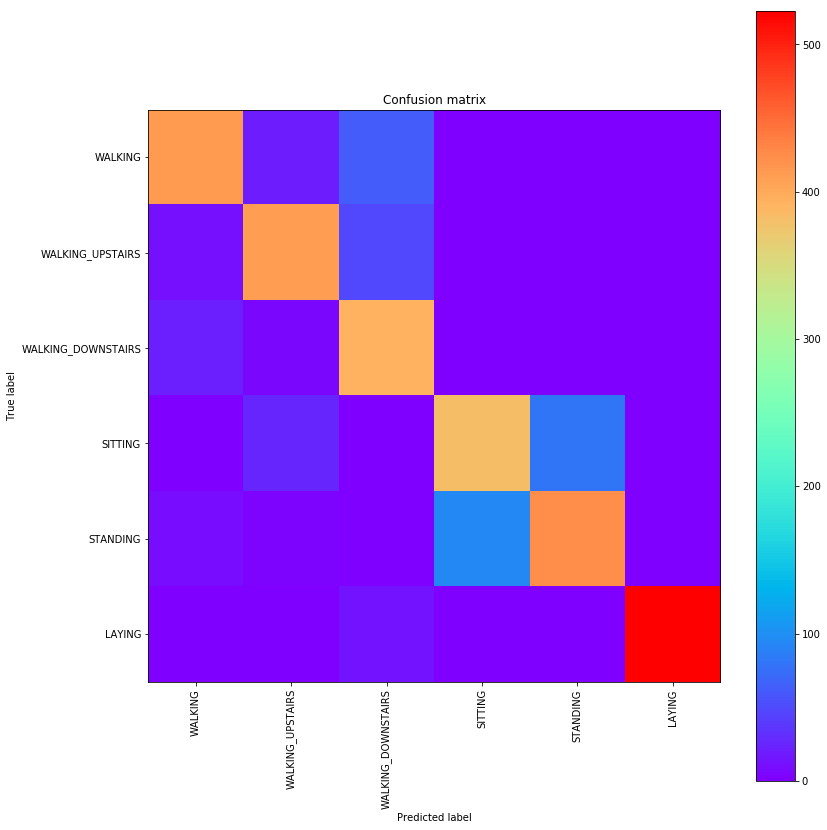

In [13]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    confusion.eval(session=sess), 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Results

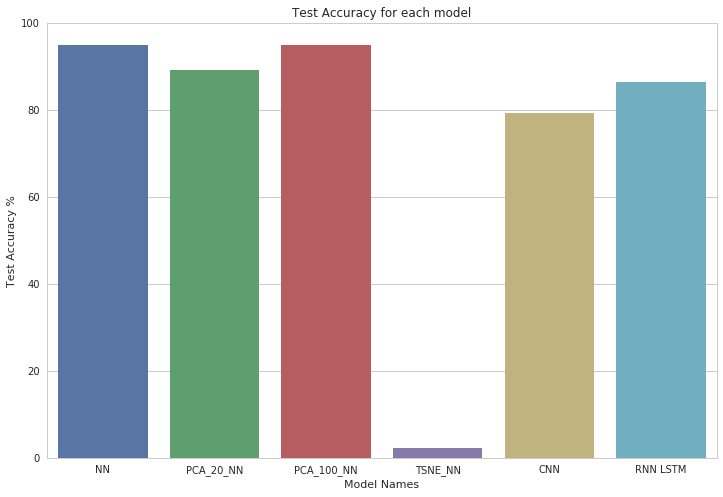

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")
model_names = ['NN', 'PCA_20_NN', 'PCA_100_NN', 'TSNE_NN', 'CNN', 'RNN LSTM']
model_accuracy = [94.9, 89.3, 95.0, 2.3, 79.3, 86.4]
sns.barplot(model_names, model_accuracy)
plt.ylim(0, 100)
plt.ylabel('Test Accuracy %')
plt.xlabel('Model Names')
plt.title('Test Accuracy for each model')
plt.show()